# Regression Example
This notebook is for illustrating the effects of adversarial transformers on a progressive learner for regression. We will run toy experiments with a normally trained transformer and an adversarial transformer in the same progressive learner using a SimpleAverage decider. With this toy example, we train the normal transformer on the data y=x.

We will run 3 experiments using an adversarial transformer:
1. that outputs random partitions
2. that is trained on y=0 data
3. that is trained on very noisy y=x data

To show that adversarial transformers are bad, we would expect the generalization error of the data predicted by the adversarial transformer to be higher than that of the normal transformer.

In [1]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from math import log2, ceil

C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\ten

In [2]:
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleAverage, LinearRegressionDecider
from proglearn.transformers import TreeRegressionTransformer
from proglearn.voters import TreeRegressionVoter
from joblib import Parallel, delayed

Using TensorFlow backend.


# Experiment 2
Adversarial transformer trained on y=0 data

slope = [[1.]]
intercept = [-2.08166817e-17]
y = [1.]x + [-2.08166817e-17]


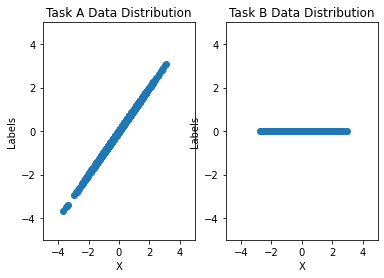

In [3]:
#Create the Task A dataset
X, y, coef = make_regression(n_samples=1000, n_features=1, n_informative=1, noise=0.1, coef=True, bias=0.0)

#Use linear regression to find the true values
regressor = LinearRegression()
regressor.fit(X, y)

#Plot the actual Task A data of y = x
y = (y - regressor.intercept_) / regressor.coef_
y = y.reshape(X.shape[0], -1)
regressor.fit(X, y)

fig = plt.figure()
a1 = fig.add_subplot(1,2,1)
a2 = fig.add_subplot(1,2,2)

a1.scatter(X, y)
a1.set_title('Task A Data Distribution')
a1.set_xlabel('X')
a1.set_ylabel('Labels')
a1.set_xlim([-5, 5])
a1.set_ylim([-5, 5])

print('slope = ' + str(regressor.coef_))
print('intercept = ' + str(regressor.intercept_))
print('y = ' + str(regressor.coef_[0]) + 'x + ' + str(regressor.intercept_))

task_A_data = np.append(X, y, axis=1)

#Task B data
X, y, coef = make_regression(n_samples=1000, n_features=1, n_informative=1, noise=0.1, coef=True, bias=0.0)
regressor = LinearRegression()
regressor.fit(X, y)
y = np.zeros((X.shape[0], 1))

a2.scatter(X, y)
a2.set_title('Task B Data Distribution')
a2.set_xlabel('X')
a2.set_ylabel('Labels')
a2.set_xlim([-5, 5])
a2.set_ylim([-5, 5])

task_B_data = np.append(X, y, axis=1)

In [16]:
def createExp2Data(sample_size):
    # Create the Task A dataset
    X, y, coef = make_regression(n_samples=sample_size, n_features=1, n_informative=1, noise=0.1, coef=True, bias=0.0)

    # Use linear regression to find the true values
    regressor = LinearRegression()
    regressor.fit(X, y)
    
    # Rescale y = mx + b to be y* = x, where y* = (y - b) / m
    y = (y - regressor.intercept_) / regressor.coef_
    y = y.reshape(X.shape[0], -1)
    
    task_A_data = np.append(X, y, axis=1)
    
    # Test B data
    X_new, y_new = make_regression(n_samples=sample_size, n_features=1, n_informative=1, noise=0.1, bias=0.0)
    regressor.fit(X_new, y_new)
    y_new = np.zeros((X_new.shape[0], 1))
    task_B_data = np.append(X_new, y_new, axis=1)
    
    return task_A_data, task_B_data

In [17]:
def experiment2(n_task_A, n_task_B, n_test=0.25, n_trees=10, max_depth=None, cur_depth=None, acorn=None):
    
    if acorn != None:
        np.random.seed(acorn)
        
    errors = np.zeros(3, dtype=float)
    
    transformer_voter_decider_split = [0.67, 0.33, 0]
    
    default_transformer_class = TreeRegressionTransformer
    taskA_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}
    taskB_transformer_kwargs = {"kwargs": {"max_depth": cur_depth}}

    #Not implemented
#     taskB_transformer_class = TreeRegressionRandomTransformer

    default_voter_class = TreeRegressionVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleAverage
    default_decider_kwargs = {}

    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class, 
                                             default_transformer_kwargs = taskA_transformer_kwargs,
                                             default_voter_class = default_voter_class,
                                             default_voter_kwargs = default_voter_kwargs,
                                             default_decider_class = default_decider_class,
                                             default_decider_kwargs = default_decider_kwargs)

    # Create data
    taskA_data, taskB_data = createExp2Data(n_task_A)
    
    # Split task data into train/test
    taskA_x_train, taskA_x_test, taskA_label_train, taskA_label_test = train_test_split(taskA_data[:,0], 
                                                                                        taskA_data[:,1], 
                                                                                        test_size=n_test, 
                                                                                        random_state=7)

    taskB_x_train, taskB_x_test, taskB_label_train, taskB_label_test = train_test_split(taskB_data[:,0], 
                                                                                        taskB_data[:,1], 
                                                                                        test_size=n_test, 
                                                                                        random_state=7)
    
    taskA_x_train = taskA_x_train.reshape(-1, 1)
    taskA_x_test = taskA_x_test.reshape(-1, 1)
    taskA_label_train = taskA_label_train.reshape(-1, 1)
    taskA_label_test = taskA_label_test.reshape(-1, 1)

    taskB_x_train = taskB_x_train.reshape(-1, 1)
    taskB_x_test = taskB_x_test.reshape(-1, 1)
    taskB_label_train = taskB_label_train.reshape(-1, 1)
    taskB_label_test = taskB_label_test.reshape(-1, 1)

    if (n_task_A == 0):
        progressive_learner.add_task(taskB_x_train, taskB_label_train)
        l2f_taskB = progressive_learner.predict(taskB_x_test, transformer_ids=[0], task_id=0)

        errors[0] = 0.5
        errors[1] = mean_squared_error(lf2_taskB, taskB_label_test)
        
    elif (n_task_B == 0):
        progressive_learner.add_task(taskA_x_train, taskA_label_train)
        l2f_taskA = progressive_learner.predict(taskA_x_test, transformer_ids=[0], task_id=0)

        errors[0] = mean_squared_error(l2f_taskA, taskA_label_test)
        errors[1] = 0.5
        
    else:
        # Add tasks to progressive learner
        progressive_learner.add_task(taskA_x_train, taskA_label_train)
#         progressive_learner.add_task(taskB_x_train, taskB_label_train)
        
        # Predict and record loss without adversarial transformer
        l2f_taskA = progressive_learner.predict_proba(taskA_x_test, transformer_ids=[0], task_id=0)
        errors[0] = mean_squared_error(l2f_taskA, taskA_label_test)
        
        # Create adversarial transformer
        progressive_learner.add_transformer(taskB_x_train, taskB_label_train,
                                            transformer_class=default_transformer_class,
                                            transformer_kwargs=taskB_transformer_kwargs,
                                            voter_class=default_voter_class,
                                            voter_kwargs=default_voter_kwargs,
                                            transformer_id=1
                                           )
        # Predict and record loss with adversarial transformer
        l2f_taskA_adversarial = progressive_learner.predict_proba(taskA_x_test, transformer_ids=[0, 1], task_id=0)
        errors[1] = mean_squared_error(l2f_taskA_adversarial, taskA_label_test)
        
        # Predict with inference through adversarial 
        l2f_taskA_adversarial_only = progressive_learner.predict_proba(taskA_x_test, transformer_ids=[1], task_id=0)
        errors[2] = mean_squared_error(l2f_taskA_adversarial_only, taskA_label_test)
        
    return errors

In [18]:
# Set up the tree parameters
mc_rep = 100
n_test = 0.25
n_trees = 10
n_sample_size = 1000
max_depth = 30

range_depths = (100*np.arange(0.01, 0.31, step=0.01)).astype(int)

# Initiate error arrays
mean_error = np.zeros((3, len(range_depths)))
std_error = np.zeros((3, len(range_depths)))

# Initiate transfer efficiencies
mean_te = np.zeros((1, len(range_depths)))
std_te = np.zeros((1, len(range_depths)))

# Iterate over the depths
for i, n1 in enumerate(range_depths):
    print('starting to compute, depth=%s\n' %n1)
    error = np.array(
        Parallel(n_jobs=-1, verbose=1)(
            delayed(experiment2)(
                n_sample_size, n_sample_size, n_test=n_test, n_trees=n_trees, cur_depth=n1, max_depth=max_depth
            ) for _ in range(mc_rep)
        )
    )
    mean_error[:, i] = np.mean(error, axis=0)
    std_error[:, i] = np.std(error, ddof=1, axis=0)
    
    mean_te[0, i] = np.mean(error[:, 0]) / np.mean(error[:, 1])
        

with open('./data/mean_setting2.pickle', 'wb') as f:
    pickle.dump(mean_error, f)
    
with open('./data/std_setting2', 'wb') as f:
    pickle.dump(std_error, f)

with open('./data/mean_te_setting2', 'wb') as f:
    pickle.dump(mean_te, f)

starting to compute, depth=1



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=2



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=3



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=4



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=5



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=6



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=6



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=8



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=9



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=10



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=11



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=12



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=13



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=14



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=15



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=16



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=17



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=18



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=19



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=20



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=21



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=22



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=23



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=24



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=25



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=26



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=27



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=28



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=29



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=30



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


# Experiment 3
Adversarial transformer trained on noisy, low-sampled, y=x data

slope = [[1.]]
intercept = [-2.34187669e-17]
y = [1.]x + [-2.34187669e-17]


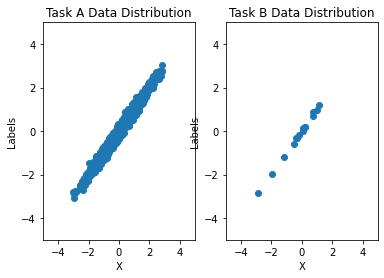

In [7]:
#Create the Task A dataset
X, y, coef = make_regression(n_samples=1000, n_features=1, n_informative=1, noise=0.1, coef=True, bias=0.0)

#Use linear regression to find the true values
regressor = LinearRegression()
regressor.fit(X, y)

#Plot the actual Task A data of y = x
y = (y - regressor.intercept_) / regressor.coef_
y = y.reshape(X.shape[0], -1)
regressor.fit(X, y)

fig = plt.figure()
a1 = fig.add_subplot(1,2,1)
a2 = fig.add_subplot(1,2,2)

a1.scatter(X, y)
a1.set_title('Task A Data Distribution')
a1.set_xlabel('X')
a1.set_ylabel('Labels')
a1.set_xlim([-5, 5])
a1.set_ylim([-5, 5])

print('slope = ' + str(regressor.coef_))
print('intercept = ' + str(regressor.intercept_))
print('y = ' + str(regressor.coef_[0]) + 'x + ' + str(regressor.intercept_))

task_A_data = np.append(X, y, axis=1)

#Task B data
X_new, y_new = make_regression(n_samples=int(ceil(np.sqrt(1000))/2), n_features=1, n_informative=1, noise=2.0, bias=0.0)
regressor.fit(X_new, y_new)
y_new = (y_new - regressor.intercept_) / regressor.coef_
y_new = y_new.reshape(X_new.shape[0], -1)
task_B_data = np.append(X_new, y_new, axis=1)

a2.scatter(X_new, y_new)
a2.set_title('Task B Data Distribution')
a2.set_xlabel('X')
a2.set_ylabel('Labels')
a2.set_xlim([-5, 5])
a2.set_ylim([-5, 5])

task_B_data = np.append(X_new, y_new, axis=1)

In [36]:
def createExp3Data(sample_size):
    # Create the Task A dataset
    X, y, coef = make_regression(n_samples=sample_size, n_features=1, n_informative=1, noise=0.1, coef=True, bias=0.0)

    # Use linear regression to find the true values
    regressor = LinearRegression()
    regressor.fit(X, y)
    
    # Rescale y = mx + b to be y* = x, where y* = (y - b) / m
    y = (y - regressor.intercept_) / regressor.coef_
    y = y.reshape(X.shape[0], -1)
    
    task_A_data = np.append(X, y, axis=1)
    
    # Test B data
    sampleB = int(ceil(np.sqrt(sample_size)))
    
    X_new, y_new = make_regression(n_samples=int(sampleB), n_features=1, n_informative=1, noise=2.0, bias=0.0)
    regressor.fit(X_new, y_new)
    y_new = (y_new - regressor.intercept_) / regressor.coef_
    y_new = y_new.reshape(X_new.shape[0], -1)
    task_B_data = np.append(X_new, y_new, axis=1)
    
    return task_A_data, task_B_data

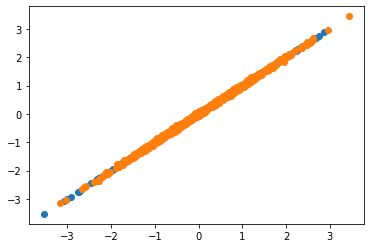

In [37]:
taskA_data, taskB_data = createExp3Data(1000)
plt.scatter(taskA_data[:, 0], taskA_data[:, 1])
plt.scatter(taskB_data[:, 0], taskB_data[:, 1])

In [26]:
def experiment3(n_task_A, n_task_B, n_test=0.25, n_trees=10, max_depth=None, cur_depth=None, acorn=None):
    
    if acorn != None:
        np.random.seed(acorn)
        
    errors = np.zeros(3, dtype=float)
    
    transformer_voter_decider_split = [0.67, 0.33, 0]
    
    default_transformer_class = TreeRegressionTransformer
    taskA_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}
    taskB_transformer_kwargs = {"kwargs": {"max_depth": cur_depth}}

    #Not implemented
#     taskB_transformer_class = TreeRegressionRandomTransformer

    default_voter_class = TreeRegressionVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleAverage
    default_decider_kwargs = {}

    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class, 
                                             default_transformer_kwargs = taskA_transformer_kwargs,
                                             default_voter_class = default_voter_class,
                                             default_voter_kwargs = default_voter_kwargs,
                                             default_decider_class = default_decider_class,
                                             default_decider_kwargs = default_decider_kwargs)

    # Create data
    taskA_data, taskB_data = createExp3Data(n_task_A)
    
    # Split task data into train/test
    taskA_x_train, taskA_x_test, taskA_label_train, taskA_label_test = train_test_split(taskA_data[:,0], 
                                                                                        taskA_data[:,1], 
                                                                                        test_size=n_test, 
                                                                                        random_state=7)

    taskB_x_train, taskB_x_test, taskB_label_train, taskB_label_test = train_test_split(taskB_data[:,0], 
                                                                                        taskB_data[:,1], 
                                                                                        test_size=n_test, 
                                                                                        random_state=7)
    
    taskA_x_train = taskA_x_train.reshape(-1, 1)
    taskA_x_test = taskA_x_test.reshape(-1, 1)
    taskA_label_train = taskA_label_train.reshape(-1, 1)
    taskA_label_test = taskA_label_test.reshape(-1, 1)

    taskB_x_train = taskB_x_train.reshape(-1, 1)
    taskB_x_test = taskB_x_test.reshape(-1, 1)
    taskB_label_train = taskB_label_train.reshape(-1, 1)
    taskB_label_test = taskB_label_test.reshape(-1, 1)

    if (n_task_A == 0):
        progressive_learner.add_task(taskB_x_train, taskB_label_train)
        l2f_taskB = progressive_learner.predict(taskB_x_test, transformer_ids=[0], task_id=0)

        errors[0] = 0.5
        errors[1] = mean_squared_error(lf2_taskB, taskB_label_test)
        
    elif (n_task_B == 0):
        progressive_learner.add_task(taskA_x_train, taskA_label_train)
        l2f_taskA = progressive_learner.predict(taskA_x_test, transformer_ids=[0], task_id=0)

        errors[0] = mean_squared_error(l2f_taskA, taskA_label_test)
        errors[1] = 0.5
        
    else:
        # Add tasks to progressive learner
        progressive_learner.add_task(taskA_x_train, taskA_label_train)
#         progressive_learner.add_task(taskB_x_train, taskB_label_train)
        
        # Predict and record loss without adversarial transformer
        l2f_taskA = progressive_learner.predict_proba(taskA_x_test, transformer_ids=[0], task_id=0)
        errors[0] = mean_squared_error(l2f_taskA, taskA_label_test)
        
        # Create adversarial transformer
        progressive_learner.add_transformer(taskB_x_train, taskB_label_train,
                                            transformer_class=default_transformer_class,
                                            transformer_kwargs=taskB_transformer_kwargs,
                                            voter_class=default_voter_class,
                                            voter_kwargs=default_voter_kwargs,
                                            transformer_id=1
                                           )
        # Predict and record loss with adversarial transformer
        l2f_taskA_adversarial = progressive_learner.predict_proba(taskA_x_test, transformer_ids=[0, 1], task_id=0)
        errors[1] = mean_squared_error(l2f_taskA_adversarial, taskA_label_test)
        
        # Predict with inference through adversarial 
        l2f_taskA_adversarial_only = progressive_learner.predict_proba(taskA_x_test, transformer_ids=[1], task_id=0)
        errors[2] = mean_squared_error(l2f_taskA_adversarial_only, taskA_label_test)
        
    return errors

In [27]:
# Set up the tree parameters
mc_rep = 100
n_test = 0.25
n_trees = 10
n_sample_size = 1000
max_depth = 30

range_depths = (100*np.arange(0.01, 0.31, step=0.01)).astype(int)

# Initiate error arrays
mean_error = np.zeros((3, len(range_depths)))
std_error = np.zeros((3, len(range_depths)))

# Initiate transfer efficiencies
mean_te = np.zeros((1, len(range_depths)))
std_te = np.zeros((1, len(range_depths)))

# Iterate over the depths
for i, n1 in enumerate(range_depths):
    print('starting to compute, depth=%s\n' %n1)
    error = np.array(
        Parallel(n_jobs=-1, verbose=1)(
            delayed(experiment3)(
                n_sample_size, n_sample_size, n_test=n_test, n_trees=n_trees, cur_depth=n1, max_depth=max_depth
            ) for _ in range(mc_rep)
        )
    )
    mean_error[:, i] = np.mean(error, axis=0)
    std_error[:, i] = np.std(error, ddof=1, axis=0)
    
    mean_te[0, i] = np.mean(error[:, 0]) / np.mean(error[:, 1])
        

with open('./data/mean_setting3.pickle', 'wb') as f:
    pickle.dump(mean_error, f)
    
with open('./data/std_setting3', 'wb') as f:
    pickle.dump(std_error, f)

with open('./data/mean_te_setting3', 'wb') as f:
    pickle.dump(mean_te, f)

starting to compute, depth=1



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=2



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=3



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=4



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=5



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=6



[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=6



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=8



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=9



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=10



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=11



[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=12



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=13



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=14



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=15



[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=16



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=17



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=18



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=19



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=20



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=21



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=22



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=23



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=24



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=25



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=26



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=27



[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=28



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=29



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute, depth=30



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


# Plots

Text(0, 0.5, 'Mean MSE')

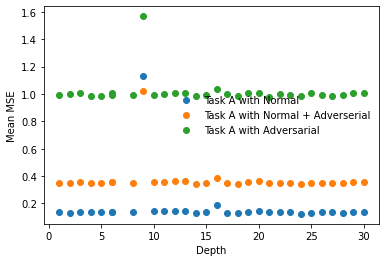

In [19]:
with open('data/mean_setting2.pickle','rb') as f:
    mean_error = pickle.load(f)

range_depths = (100*np.arange(0.01, 0.31, step=0.01)).astype(int)

plt.scatter(range_depths, mean_error[0,:], label='Task A with Normal')
plt.scatter(range_depths, mean_error[1,:], label='Task A with Normal + Adverserial')
plt.scatter(range_depths, mean_error[2,:], label='Task A with Adversarial')
plt.legend(loc='right', frameon=False)
plt.xlabel('Depth')
plt.ylabel('Mean MSE')

Text(0, 0.5, 'Mean MSE')

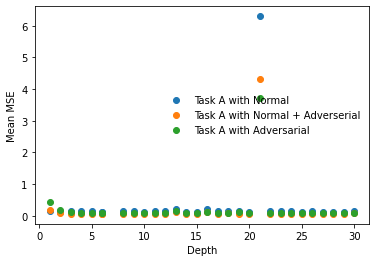

In [28]:
with open('data/mean_setting3.pickle','rb') as f:
    mean_error = pickle.load(f)

range_depths = (100*np.arange(0.01, 0.31, step=0.01)).astype(int)

plt.scatter(range_depths, mean_error[0,:], label='Task A with Normal')
plt.scatter(range_depths, mean_error[1,:], label='Task A with Normal + Adverserial')
plt.scatter(range_depths, mean_error[2,:], label='Task A with Adversarial')
plt.legend(loc='right', frameon=False)
plt.xlabel('Depth')
plt.ylabel('Mean MSE')